# Journal Analysis

In [1]:
import pandas as pd
import seaborn as sns
import sqlitedict
from matplotlib import pyplot as plt
import numpy as np

In [2]:
metadata = sqlitedict.SqliteDict('../synth/data/doi_metadata.db')
journal_list = []
for k, v in metadata.items():
    issns = v.get('issn-type', [])
    if len(issns) == 0:
        continue
    try:
        issn = next(i for i in issns if i['type'] == 'print')['value']
    except StopIteration:
        issn = issns[0]['value']
    journal_list.append({'ISSN': issn.replace('-', ''), 'Count': 1})

journal_list_df = pd.DataFrame(journal_list)

Load the 2019 CiteScore data downloaded from https://www.scopus.com/sources.

In [6]:
scopus = pd.read_csv('scopus-citescore.csv', delimiter='\t')

# we don't need every column
scopus = scopus.loc[:,['Open Access', 'CiteScore', 'Print ISSN', 'E-ISSN', 'Scopus Sub-Subject Area']]

# rename the 'Sub-Subject Area' column
scopus['Subject'] = scopus['Scopus Sub-Subject Area']
scopus = scopus.drop('Scopus Sub-Subject Area', axis=1)

# combine the print + electronic ISSNs and split multiple ISSNs into separate rows
scopus['ISSN'] = scopus['Print ISSN'].astype(str) + ' ' + scopus['E-ISSN'].astype(str)
scopus.ISSN = scopus.ISSN.apply(lambda x: [y.strip() for y in x.split(' ')])
scopus = scopus.explode('ISSN').drop('Print ISSN', axis=1).drop('E-ISSN', axis=1)
scopus = scopus[scopus.ISSN != 'nan']

# format the values in the access column
scopus['Open Access'] = scopus['Open Access'].replace('YES', 'Open').replace('NO', 'Not Open')

Load the 2019 Scimago Journal Rank data downloaded from https://www.scimagojr.com/journalrank.php.

In [4]:
sjr = pd.read_csv('scimagojr 2019.csv', delimiter=';')

# we don't need every column
sjr = sjr.loc[:, ['Issn', 'Rank', 'SJR', 'H index', 'Region', 'Publisher']]

# split multiple ISSNs into separate rows
sjr.Issn = sjr.Issn.apply(lambda x: [y.strip() for y in x.split(',')])
sjr = sjr.explode('Issn')

# reformat the SJR values as floats
sjr.SJR = sjr.SJR.apply(lambda x: str(x).replace(',', '.')).astype(float)

Join the three dataframes together.

In [7]:
df = journal_list_df.set_index('ISSN').join(scopus.set_index('ISSN'), how='inner', rsuffix='scopus')
df = df.join(sjr.set_index('Issn'), how='inner', rsuffix='sjr')
df

,Count,Open Access,CiteScore,Subject,Rank,SJR,H index,Region,Publisher
0003004X,1,Not Open,5.3,Geophysics,2044,1.573,131,Northern America,Walter de Gruyter GmbH
0003004X,1,Not Open,5.3,Geochemistry and Petrology,2044,1.573,131,Northern America,Walter de Gruyter GmbH
0003004X,1,Not Open,5.3,Geophysics,2044,1.573,131,Northern America,Walter de Gruyter GmbH
0003004X,1,Not Open,5.3,Geochemistry and Petrology,2044,1.573,131,Northern America,Walter de Gruyter GmbH
0003004X,1,Not Open,5.3,Geophysics,2044,1.573,131,Northern America,Walter de Gruyter GmbH
...,...,...,...,...,...,...,...,...,...
23915412,1,Open,1.1,General Immunology and Microbiology,18303,0.204,30,Western Europe,Walter de Gruyter GmbH
23915412,1,Open,1.1,General Neuroscience,18303,0.204,30,Western Europe,Walter de Gruyter GmbH
23915412,1,Open,1.1,General Agricultural and Biological Sciences,18303,0.204,30,Western Europe,Walter de Gruyter GmbH
25314033,1,Open,2.3,"Ecology, Evolution, Behavior and Systematics",11022,0.437,15,Eastern Europe,Pensoft Publishers


In [34]:
subject_counts = df.loc[:,['Subject', 'Count']].groupby('Subject').count().sort_values(['Count'], ascending=False)
subjects = subject_counts.head(10).index

# there are too many subjects to show all of them, so only use the top 10.
subject_df = df[df.Subject.isin(subjects)]
subject_df

,Count,Open Access,CiteScore,Subject,Rank,SJR,H index,Region,Publisher
0007196X,1,Not Open,1.4,"Ecology, Evolution, Behavior and Systematics",12106,0.384,27,Northern America,Springer New York
0007196X,1,Not Open,1.4,Plant Science,12106,0.384,27,Northern America,Springer New York
0008347X,1,Not Open,2.2,"Ecology, Evolution, Behavior and Systematics",10289,0.473,40,Western Europe,Cambridge University Press
0008347X,1,Not Open,2.2,Insect Science,10289,0.473,40,Western Europe,Cambridge University Press
0008347X,1,Not Open,2.2,"Ecology, Evolution, Behavior and Systematics",10289,0.473,40,Western Europe,Cambridge University Press
...,...,...,...,...,...,...,...,...,...
2353074X,1,Open,0.8,Plant Science,17604,0.217,3,Eastern Europe,Polish Botanical Society
23818107,1,Not Open,2.2,Plant Science,12084,0.385,18,Western Europe,Taylor and Francis Ltd.
23818107,1,Not Open,2.2,Plant Science,12084,0.385,18,Western Europe,Taylor and Francis Ltd.
25314033,1,Open,2.3,"Ecology, Evolution, Behavior and Systematics",11022,0.437,15,Eastern Europe,Pensoft Publishers


Define a function to display a specific metric and facet.

In [35]:
sns.set_theme(style='darkgrid')

def visualise(metric, facet, title):
    start_df = subject_df if facet == 'Subject' else df
    
    graph_df = start_df.loc[:, [metric, facet, 'Count']]
    metric_summary = graph_df.groupby([metric]).sum().reset_index()
    metric_summary[facet] = pd.Series(['Total'] * metric_summary.shape[0])
    graph_df = pd.concat([graph_df, metric_summary]).replace(0, np.NaN).dropna()
    
    w = max(len(graph_df[facet].unique()), 8)
    h = 10
    
    fig, ax = plt.subplots(figsize=(w, h))
    sns.stripplot(data=graph_df, x=facet, y=metric, hue=facet, size=5, alpha=0.5, palette='Set2')
    ax.legend().remove()
    
    plt.xticks(rotation=90)
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    sns.despine()
    plt.show()

## CiteScore

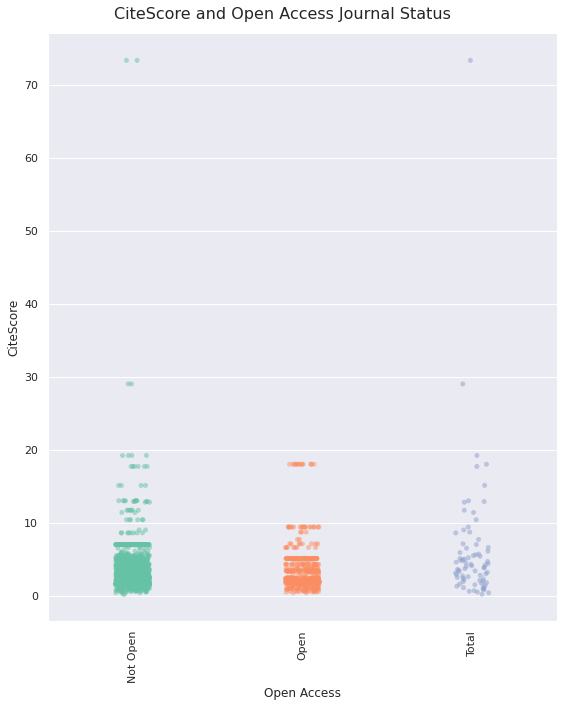

In [36]:
visualise('CiteScore', 'Open Access', 'CiteScore and Open Access Journal Status')

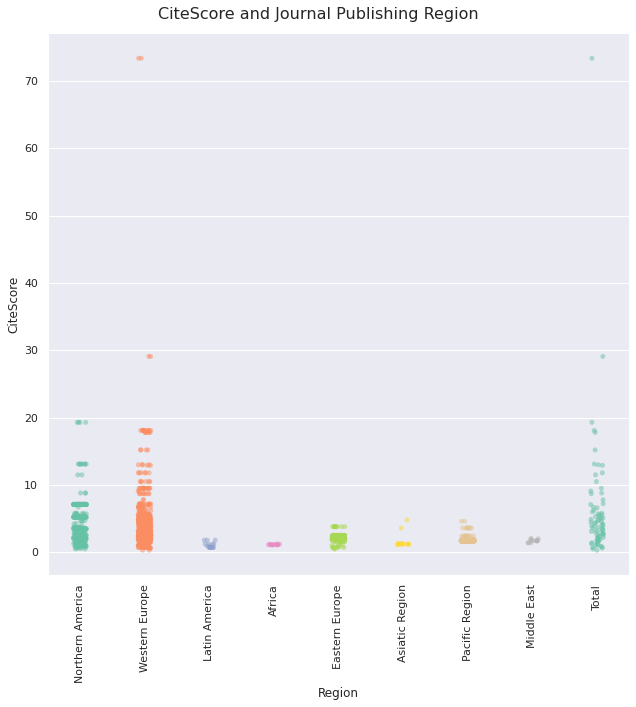

In [14]:
visualise('CiteScore', 'Region', 'CiteScore and Journal Publishing Region')

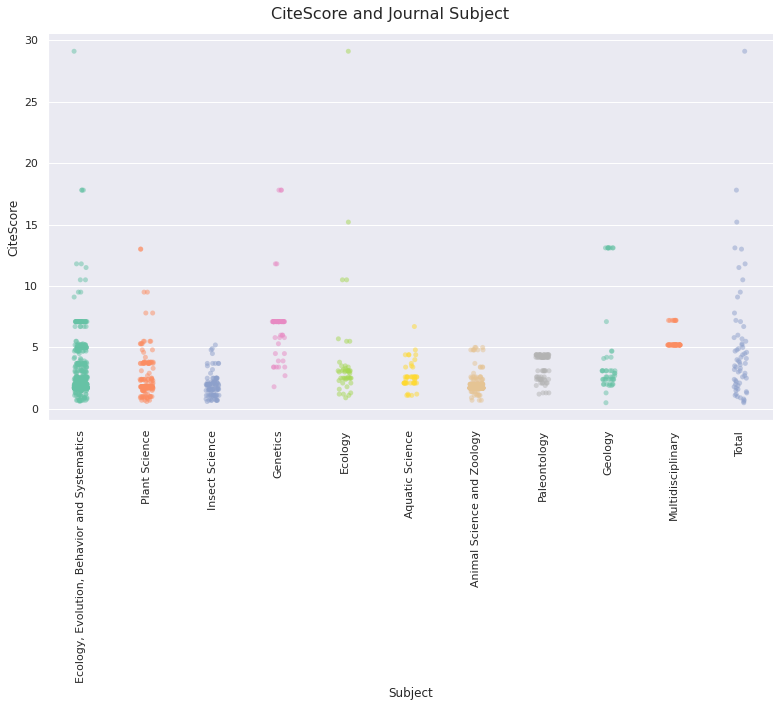

In [37]:
visualise('CiteScore', 'Subject', 'CiteScore and Journal Subject')

## Scimago Journal Rank

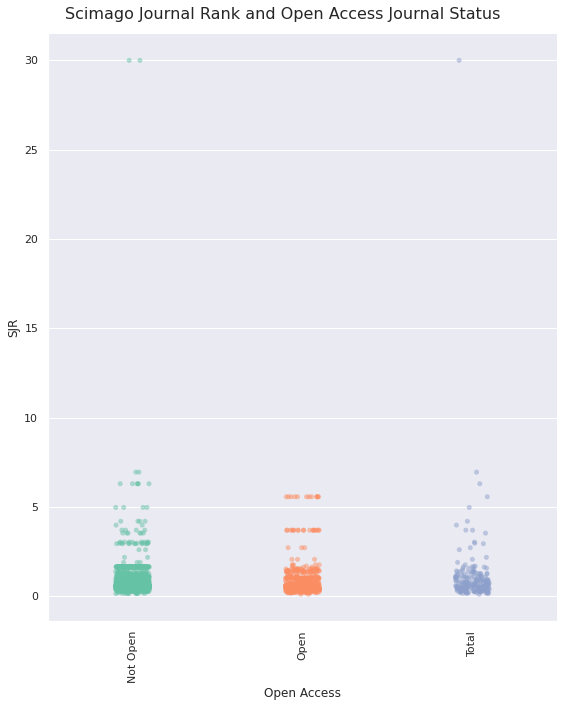

In [15]:
visualise('SJR', 'Open Access', 'Scimago Journal Rank and Open Access Journal Status')

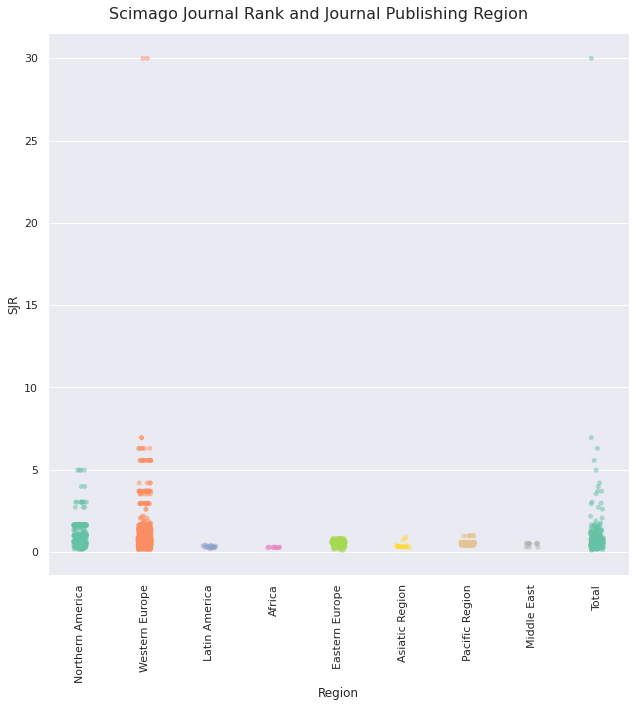

In [16]:
visualise('SJR', 'Region', 'Scimago Journal Rank and Journal Publishing Region')

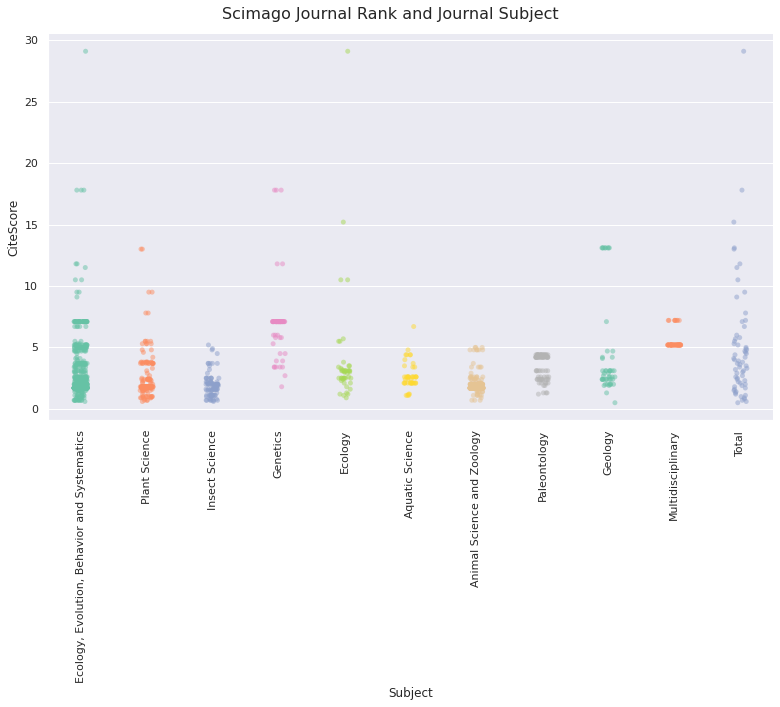

In [38]:
visualise('CiteScore', 'Subject', 'Scimago Journal Rank and Journal Subject')

## H-Index

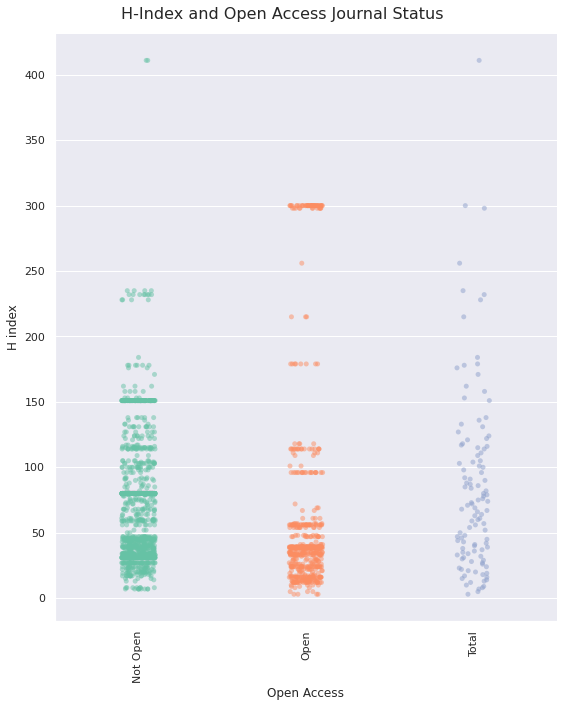

In [17]:
visualise('H index', 'Open Access', 'H-Index and Open Access Journal Status')

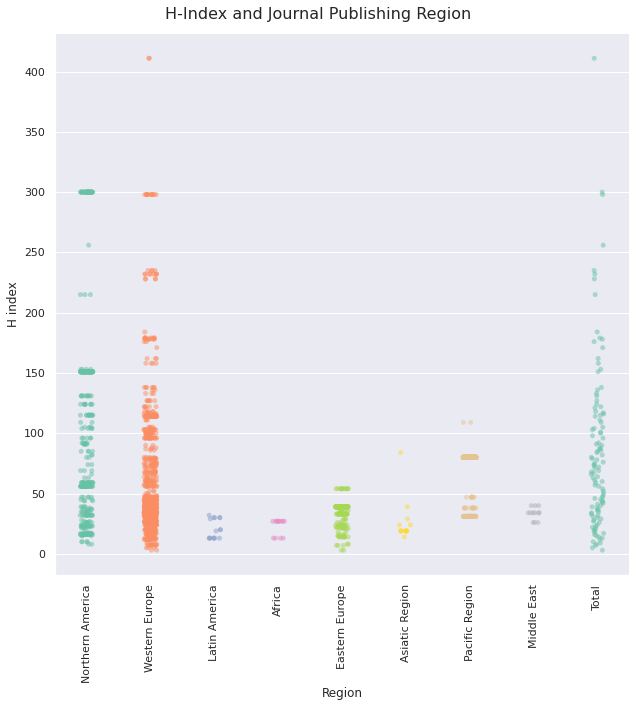

In [18]:
visualise('H index', 'Region', 'H-Index and Journal Publishing Region')